Importation des packages

In [4]:
!pip install py7zr geojson geopandas openpyxl tqdm s3fs
!pip install PyYAML xlrd
!pip install git+https://github.com/inseefrlab/cartiflette

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 11.1 MB/s eta 0:00:00
  Cloning https://github.com/inseefrlab/cartiflette to /tmp/pip-req-build-ren92nor
  Running command git clone --filter=blob:none --quiet https://github.com/inseefrlab/cartiflette /tmp/pip-req-build-ren92nor
  Cloning https://github.com/inseefrlab/cartiflette to /tmp/pip-req-build-zt3uxf0u
  Running command git clone --filter=blob:none --quiet https://github.com/inseefrlab/cartiflette /tmp/pip-req-build-zt3uxf0u
  Resolved https://github.com/inseefrlab/cartiflette to commit f6b0c5d049bd6dcae7b437bd931957371da24278
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 14.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 50.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━

In [5]:
import pandas as pd
import numpy as np
import geopandas as gpd
import geojson
import requests
import time
import os
import re
import magic
import matplotlib.pyplot as plt
import zipfile
import cartiflette
from io import StringIO

This is an experimental version of cartiflette published on PyPi.
To use the latest stable version, you can install it directly from GitHub with the following command:
pip install git+https://github.com/inseeFrLab/cartiflette.git


Description des variables de ce dataframe :
- idmutinvar = identifiant unique entre les diff bases pour retrouver chaque mutation
- idopendata = identifiant de mutation utilisé depuis l'ouverture de données DVF
- datemut = date de signature de l'acte de vente
- anneemut = annee de signature du doc
- codedep
- libnatmut = Libellé de nature de mutation tel que défini dans la donnée source DVF 6 catégories : Vente, Vente en l'état futur d'achèvement, Adjudication, Echange, Vente terrain à bâtir et Expropriation.
- vefa = booléen selon si la vente est en VEFA (vente en l'état futur d'achèvement) ou non
- valeurfonc = valeur foncière en euro déclarée lors de la vente ; prix net vendeur, inclut la TVA mais n'inclut pas les frais de notaire, d'agence ou des meubles. 
- nbcomm = nombre de communes concernée par la mutation (i.e. sur lesquelles se trouve la parcelle cadastrale concernée par la mutation)
- nbpar = comme nbcomm mais pour les parcelles.
- nbparmut = nb de parcelles ayant muté (i.e. dont la pleine propriété a été transférée lors de la mutation)
- sterr = surface de terrain ayant muté (mutation = transfert de propriété, donc surface de terrain ayant muté = surface du terrain qui a été vendu)
- nbvolmut = variable obscure, flemme 
- nblocmut = nb de locaux ayant muté
- sbati = surface de l'ensemble du bati ayant muté
- codtypbien = typologie des biens ; on pourra s'en servir pour filter les maisons et appartements et virer tous les types de batiments bizarres (cf schéma ici) https://doc-datafoncier.cerema.fr/doc/dv3f/mutation/codtypbien
- libtypbien = comme codtypbien mais pour la base DV3F et non issu de juste DVF
- geometry
- l_codeinsee = liste des codes INSEE des communes concernées par la mutation
- l_idpar =Liste des idpar qui composent l’entité (idpar = Identifiant de parcelle)
- l_idparmut = liste des identifiants de parcelles ayant muté (idpar)
- l_idlocmut = liste des identifiants de locaux ayant muté (idloc)

On veut d'abord récupérer les données de la base DVF à partir de l'API publique dédiée. On peut regarder la documentation de cette API sur le site suivant : 
https://apidf-preprod.cerema.fr/swagger/#/DVF%2B%20(acc%C3%A8s%20libre)/dvf_opendata_geomutations_list


I. Importation des données DVF

A. Paramétrage de l'API

In [9]:
def cleaning_json_for_gpd(data):
    for feature in data["features"]:
        properties = feature["properties"]
        for key, value in properties.items():
            if isinstance(value, list):  # Vérifie si c'est une liste
                properties[key] = ", ".join(map(str, value))  # Convertit en chaîne séparée par des virgules

In [10]:
def recup_donnees_dvf(code_insee,annee_mut):
        url = base_api_dvf_url + f"/dvf_opendata/geomutations/?anneemut={annee_mut}&code_insee={code_insee}&page_size=300"
        response = requests.get(url)
        data = response.json()
        cleaning_json_for_gpd(data)
        mut_gdf_tempo = gpd.GeoDataFrame.from_features(data["features"])
        col_mut = mut_gdf_tempo.columns
        mut_gdf = gpd.GeoDataFrame(columns=col_mut)

        while url != None : 
                response = requests.get(url)
                if response.status_code == 200:
                        data = response.json()
                        url = data['next']
                        cleaning_json_for_gpd(data) #transforme le dictionary qu'est data en un dataframe
                        mut_gdf_tempo = gpd.GeoDataFrame.from_features(data["features"])
                        mut_gdf = pd.concat([mut_gdf, mut_gdf_tempo], axis=0)
                    
                else:
                        print(f"Erreur : {response.status_code}")
                        url = None

        return mut_gdf

In [11]:
def recup_donnees_dvf_all_years(code_insee):
        url = base_api_dvf_url + f"/dvf_opendata/geomutations/?code_insee={code_insee}&page_size=500"
        response = requests.get(url)
        data = response.json()
        cleaning_json_for_gpd(data)
        mut_gdf_tempo = gpd.GeoDataFrame.from_features(data["features"])
        col_mut = mut_gdf_tempo.columns
        mut_gdf = gpd.GeoDataFrame(columns=col_mut)

        while url != None : 
                response = requests.get(url)
                if response.status_code == 200:
                        data = response.json()
                        url = data['next']
                        print(url)
                        cleaning_json_for_gpd(data) #transforme le dictionary qu'est data en un dataframe
                        mut_gdf_tempo = gpd.GeoDataFrame.from_features(data["features"])
                        mut_gdf = pd.concat([mut_gdf, mut_gdf_tempo], axis=0)
                    
                else:
                        print(f"Erreur : {response.status_code}")
                        url = None

        return mut_gdf

On écrit la racine de l'API : 

In [12]:
base_api_dvf_url = "https://apidf-preprod.cerema.fr"

On va récupérer les données DVF des villes suivantes : 
1. Zone ouest :
- Paris 16 : 75116
- Paris 17: 75117
- Clichy : 92024
- Levallois : 92044
- Neuilly : 92051
- Boulogne-Billancourt : 92012

2. Zone sud
- Paris 13 : 75113
- Paris 14 : 75114
- Paris 15 : 75115
- Issy-les-Moulineaux : 92040
- Vanves : 92075
- Malakoff : 92046
- Montrouge : 92049
- Gentilly : 94037
- Ivry-sur-Seine : 94041


On constate en faisant tourner naïvement l'API qu'on obtient toujours des données par paquets en nombre limité (par défaut, 100). On peut modifier cela par le paramètre "page_size", mais la limite est de 500. Pour un paramètre supérieur à 500, on n'obtient que des pages de 500. 

On cherche donc à faire boucler nos requêtes à l'API jusqu'à obtenir toutes les données concernant la commune qui nous intéresse. Or on constate que la réponse "data" que l'on obtient possède une clé "next", qui donne l'url de notre requête complété par un argument "page". L'API fonctionne donc ainsi : s'il y a plus de 500 observations pour une commune, l'API nous renvoie une première page qui contient 500 observations, avec l'url pour requêter la page suivant qui contient 500 autres observations, et ainsi de suite jusqu'à la dernière page, qui donne pour valeur "None" à la clé "next". 

Le code ci-dessous permet de récupérer les données.

In [13]:
"""data_dvf_sud = recup_donnees_dvf("92040",2014) 

code_insee_ville_banlieue_sud = ["92040", "92075", "92046", "92049", "94037", "94041"]
code_insee_arrond_sud = ["75113", "75114", "75115"]

for code_insee_ville in code_insee_ville_banlieue_sud: 
    print(code_insee_ville)
    for annee in range(2013,2022):
        print(annee)
        data_temp = recup_donnees_dvf(code_insee_ville,str(annee))
        data_dvf_sud = pd.concat([data_dvf_sud, data_temp], axis = 0)

data_dvf_sud.shape"""

'data_dvf_sud = recup_donnees_dvf("92040",2014) \n\ncode_insee_ville_banlieue_sud = ["92040", "92075", "92046", "92049", "94037", "94041"]\ncode_insee_arrond_sud = ["75113", "75114", "75115"]\n\nfor code_insee_ville in code_insee_ville_banlieue_sud: \n    print(code_insee_ville)\n    for annee in range(2013,2022):\n        print(annee)\n        data_temp = recup_donnees_dvf(code_insee_ville,str(annee))\n        data_dvf_sud = pd.concat([data_dvf_sud, data_temp], axis = 0)\n\ndata_dvf_sud.shape'

In [14]:
"""data_dvf_sud = recup_donnees_dvf_all_years("92040") 

code_insee_ville_banlieue_sud = ["92075", "92046", "92049", "94037", "94041"]
code_insee_arrond_sud = ["75113", "75114", "75115"]

for code_insee_ville in code_insee_ville_banlieue_sud: 
    print(code_insee_ville)
    data_temp = recup_donnees_dvf_all_years(code_insee_ville)
    data_dvf_sud = pd.concat([data_dvf_sud, data_temp], axis = 0)

data_dvf_sud.shape"""

'data_dvf_sud = recup_donnees_dvf_all_years("92040") \n\ncode_insee_ville_banlieue_sud = ["92075", "92046", "92049", "94037", "94041"]\ncode_insee_arrond_sud = ["75113", "75114", "75115"]\n\nfor code_insee_ville in code_insee_ville_banlieue_sud: \n    print(code_insee_ville)\n    data_temp = recup_donnees_dvf_all_years(code_insee_ville)\n    data_dvf_sud = pd.concat([data_dvf_sud, data_temp], axis = 0)\n\ndata_dvf_sud.shape'

In [15]:
#data_dvf_sud.shape

Difficulté : l'API peut arrêter de nous répondre de manière imprévue au milieu de la boucle de requête des pages. Dans ce cas, toutes les données obtenues sur les pages précédentes sont perdues. On a donc intérêt, pour pouvoir travailler sereinement, à télécharger ces données. 

Pour ce faire, on va essayer, commune par commune, de requêter toutes les pages, et, AVANT de passer au requêtage pour la commune suivante, on sauvegarde notre geodataframe au format geojson. 

In [16]:
"""code_insee_pour_enregistre = ["92012"]
for code_insee in code_insee_pour_enregistre: 
    url = base_api_dvf_url + f"/dvf_opendata/geomutations/?code_insee={code_insee}&page_size=100"
    response = requests.get(url)
    data = response.json()
    print(data['count'])
    gdf = recup_donnees_dvf_all_years(code_insee)
    name = f'data/dvf/data_code_insee={code_insee}.geojson'
    gdf.to_file(name, driver="GeoJSON")
    gdf = gpd.read_file(name)
    print(len(gdf))"""

'code_insee_pour_enregistre = ["92012"]\nfor code_insee in code_insee_pour_enregistre: \n    url = base_api_dvf_url + f"/dvf_opendata/geomutations/?code_insee={code_insee}&page_size=100"\n    response = requests.get(url)\n    data = response.json()\n    print(data[\'count\'])\n    gdf = recup_donnees_dvf_all_years(code_insee)\n    name = f\'data/dvf/data_code_insee={code_insee}.geojson\'\n    gdf.to_file(name, driver="GeoJSON")\n    gdf = gpd.read_file(name)\n    print(len(gdf))'

On fait pareil pour la zone ouest de Paris

In [17]:
"""data_dvf_ouest_banlieue = recup_donnees_dvf("92040",2014) 

code_insee_ville_banlieue_ouest = ["92040", "92075", "92046", "92049", "94037", "94041"]

for code_insee_ville in code_insee_ville_banlieue_ouest: 
    print(code_insee_ville)
    for annee in range(2013,2022):
        print(annee)
        data_temp = recup_donnees_dvf(code_insee_ville,str(annee))
        data_dvf_ouest = pd.concat([data_dvf_ouest, data_temp], axis = 0)

data_dvf_ouest_banlieue.shape"""

'data_dvf_ouest_banlieue = recup_donnees_dvf("92040",2014) \n\ncode_insee_ville_banlieue_ouest = ["92040", "92075", "92046", "92049", "94037", "94041"]\n\nfor code_insee_ville in code_insee_ville_banlieue_ouest: \n    print(code_insee_ville)\n    for annee in range(2013,2022):\n        print(annee)\n        data_temp = recup_donnees_dvf(code_insee_ville,str(annee))\n        data_dvf_ouest = pd.concat([data_dvf_ouest, data_temp], axis = 0)\n\ndata_dvf_ouest_banlieue.shape'

In [18]:
"""data_dvf_ouest_paris = recup_donnees_dvf("75116",2012)

code_insee_arrond_ouest = ["75116", "75117"]

for code_insee_ville in code_insee_arrond_ouest: 
    print(code_insee_ville)
    for annee in range(2013,2022):
        print(annee)
        data_temp = recup_donnees_dvf(code_insee_ville,str(annee))
        data_dvf_ouest_paris = pd.concat([data_dvf_ouest_paris, data_temp], axis = 0)
"""

'data_dvf_ouest_paris = recup_donnees_dvf("75116",2012)\n\ncode_insee_arrond_ouest = ["75116", "75117"]\n\nfor code_insee_ville in code_insee_arrond_ouest: \n    print(code_insee_ville)\n    for annee in range(2013,2022):\n        print(annee)\n        data_temp = recup_donnees_dvf(code_insee_ville,str(annee))\n        data_dvf_ouest_paris = pd.concat([data_dvf_ouest_paris, data_temp], axis = 0)\n'

Ci-dessous, le code pour reconstituer les fichiers geojson à partir des sauvegardes faites à cause de l'API défectueuse (en deux temps : la zone ouest puis la zone sud)

In [19]:
obs_tot = 0
list_gpd_ouest = []
for geo_file in os.listdir("data/dvf/cluster_ouest"): 
    geo_file_temp = gpd.read_file("data/dvf/cluster_ouest/"+geo_file)  
    list_gpd_ouest.append(geo_file_temp)
    obs_tot += len(geo_file_temp)

all_gpd_ouest = pd.concat(list_gpd_ouest)
print(len(all_gpd_ouest), obs_tot)

134410 134410


In [20]:
obs_tot = 0
list_gpd_sud = []
for geo_file in os.listdir("data/dvf/cluster_sud"): 
    geo_file_temp = gpd.read_file("data/dvf/cluster_sud/"+geo_file)  
    obs_tot += len(geo_file_temp)
    list_gpd_sud.append(geo_file_temp)

all_gpd_sud = pd.concat(list_gpd_sud)
print(len(all_gpd_sud), obs_tot)

119319 119319


II. Récupération de données Insee par IRIS pour avoir des variables de contrôle dans notre régression

Il n'y a pas d'API permettant de récupérer les données voulues par IRIS, donc on doit passer par l'importation de tous les fichiers. On importe trois types de fichiers : un qui contient des informations sur le revenu disponible ('BASE_TD_FILO_DISP_IRIS), un qui donne des informations sur les logements ('base_ic_logement') et un sur les occupations professionnelles des habitants de l'IRIS ('base-ic-activite-residents').

In [21]:
dfs_activite = []
dfs_logement = []
dfs_revenu = []
dates_df = []


for f in os.listdir("data/insee"):
    if f.lower().endswith(".zip"): #si c'est un zip
        print(f)
        zip_file = zipfile.ZipFile("data/insee/"+f) #on le dézipe
        nom_racine_dossier = f.rsplit(".",1)[0]
        for f_in_zip in zipfile.ZipFile("data/insee/"+f).namelist():
            if f_in_zip[0:4] == "meta" :
                pass
            else :
                nom_racine_fichier = f_in_zip.rsplit(".",1)[0]
                extension = f_in_zip.rsplit(".",1)[1] #on récupère l'extension
                
                # Recherche de l'année
                schema_date = r"(\d{4})"
                match = re.search(schema_date, f)
                    
                annee_extraite = match.group(1)
                
                if extension.lower() == "csv":
                    df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension), 
                                            sep = ";", dtype = {'IRIS' : str})
                                            
                elif extension in ("xls", "xlsx"):
                    df_temp = pd.read_excel(zip_file.open(nom_racine_fichier + "." + extension),
                                            skiprows = 5, dtype = {'IRIS' : str})
                    
                df_temp['IRIS'] = df_temp['IRIS'].apply(lambda x: '0' + x if len(x) == 8 else x)
                
                deux_derniers_chiffres_annee = annee_extraite[2:4]
                df_temp['annee'] = annee_extraite
                
                if "activite" in nom_racine_fichier:
                    df_temp.columns = [col.replace(f'{deux_derniers_chiffres_annee}_', '_') for col in df_temp.columns]
                    dfs_activite.append(df_temp)
                elif "logement" in nom_racine_fichier:
                    df_temp.columns = [col.replace(f'{deux_derniers_chiffres_annee}_', '_') for col in df_temp.columns]
                    dfs_logement.append(df_temp)
                elif "DISP" in nom_racine_fichier:
                    colonnes_a_traiter = [col for col in df_temp.columns if col.endswith(deux_derniers_chiffres_annee)]
                    df_temp = df_temp.rename(columns={col: col[:-2] for col in colonnes_a_traiter})
                    dfs_revenu.append(df_temp)
                else :
                    print('un fichier n a pas été traité')

                dates_df.append(annee_extraite)
    else :
        nom_racine_fichier = f.rsplit(".",1)[0]
        extension = f.rsplit(".",1)[1] #on récupère l'extension
                
        schema_date = r"(\d{4})"
        match = re.search(schema_date, f)     
        annee_extraite = match.group(1)

        df_temp = pd.read_excel("data/insee/" + nom_racine_fichier + "." + extension,
                                            skiprows = 5, dtype = {'IRIS' : str})
                    
        df_temp['IRIS'] = df_temp['IRIS'].apply(lambda x: '0' + x if len(x) == 8 else x)
        deux_derniers_chiffres_annee = annee_extraite[2:4]
        df_temp['annee'] = annee_extraite
                
        if "DISP" in nom_racine_fichier:
            colonnes_a_traiter = [col for col in df_temp.columns if col.endswith(deux_derniers_chiffres_annee)]
            df_temp = df_temp.rename(columns={col: col[:-2] for col in colonnes_a_traiter})
            dfs_revenu.append(df_temp)

        dates_df.append(annee_extraite)


base-ic-activite-residents-2019_csv.zip


/tmp/ipykernel_100121/2103325727.py:26: DtypeWarning: Columns (1,4,81,82,83,84,85,86,91,92,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
/tmp/ipykernel_100107/2103325727.py:26: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


base-ic-activite-residents-2015.zip
base-ic-logement-2015.zip
base-ic-activite-residents-2021_csv.zip


/tmp/ipykernel_100121/2103325727.py:26: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
/tmp/ipykernel_100107/2103325727.py:26: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


BASE_TD_FILO_DISP_IRIS_2019.zip
base-ic-logement-2016.zip
base-ic-activite-residents-2016.zip
base-ic-logement-2014.zip
base-ic-logement-2017_csv.zip


/tmp/ipykernel_100121/2103325727.py:26: DtypeWarning: Columns (1,4,81,82,83,84,85,86,91,92,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
/tmp/ipykernel_100107/2103325727.py:26: DtypeWarning: Columns (1,4,81,82,83,84,85,86,91,92,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


base-ic-logement-2021_csv.zip


/tmp/ipykernel_100107/2103325727.py:26: DtypeWarning: Columns (1,3,80,81,82,83,84,85,90,91,92,93) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


BASE_TD_FILO_DISP_IRIS_2020_CSV.zip
base-ic-activite-residents-2018_csv.zip


/tmp/ipykernel_100121/2103325727.py:26: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
/tmp/ipykernel_100107/2103325727.py:26: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


base-ic-activite-residents-2020_csv.zip


/tmp/ipykernel_100121/2103325727.py:26: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
/tmp/ipykernel_100107/2103325727.py:26: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


base-ic-activite-residents-2016.zip
base-ic-logement-2019_csv.zip


/tmp/ipykernel_100121/2103325727.py:26: DtypeWarning: Columns (1,4,81,82,83,84,85,86,91,92,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


BASE_TD_FILO_DISP_IRIS_2020_XLSX.zip
base-ic-activite-residents-2017_csv.zip


/tmp/ipykernel_100121/2103325727.py:26: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
/tmp/ipykernel_100107/2103325727.py:26: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


base-ic-logement-2018_csv.zip


/tmp/ipykernel_100121/2103325727.py:26: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


base-ic-logement-2020_csv.zip


/tmp/ipykernel_100121/2103325727.py:26: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
/tmp/ipykernel_100107/2103325727.py:26: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


base-ic-activite-residents-2014.zip
base-ic-logement-2019_csv.zip


/tmp/ipykernel_100121/2103325727.py:26: DtypeWarning: Columns (1,3,80,81,82,83,84,85,90,91,92,93) have mixed types. Specify dtype option on import or set low_memory=False.
/tmp/ipykernel_100107/2103325727.py:26: DtypeWarning: Columns (1,4,81,82,83,84,85,86,91,92,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


BASE_TD_FILO_IRIS_2021_DISP_CSV.zip
BASE_TD_FILO_DISP_IRIS_2018.zip


In [22]:
dfs_clean_activite = pd.concat(dfs_activite, ignore_index = True)
dfs_clean_revenu = pd.concat(dfs_revenu, ignore_index = True)
dfs_clean_logement = pd.concat(dfs_logement, ignore_index = True)

In [23]:
print(dfs_clean_activite.shape)
print(dfs_clean_revenu.shape)
print(dfs_clean_logement.shape)


(395824, 131)
(122018, 36)
(395824, 123)


In [24]:
df_fusion_inter = pd.merge(dfs_clean_activite, dfs_clean_revenu,how = "outer", on=['IRIS','annee']) 
df_fusion_all_insee = pd.merge(df_fusion_inter, dfs_clean_logement, how = "outer",on=['IRIS', 'annee'])#, 'LIBIRIS','TYP_IRIS','MODIF_IRIS','LAB_IRIS','COM', 'LIBCOM'])

Vérifions que le dataframe obtenu n'a pas de problème.

In [25]:
print(df_fusion_inter.shape)
print(df_fusion_all_insee.shape)

(411921, 165)
(411921, 286)


III. Fusion de nos deux jeux de données


Troisième et dernière étape d'importation des données : un fichier pour faire la correspondance entre les adresses/coordonnées des données DVF et les IRIS des données Insee.

On utilise un fichier des données géographiques des IRIS d'Île-de-France.

In [26]:
iris = gpd.read_file("data/iris.geojson")  
iris = iris.to_crs(epsg=4326)  # Assurez-vous d'utiliser le même système de coordonnées (WGS84)
iris['code_iris'] = iris['code_iris'].astype(str)

On regarde dans quel système géographique est le tableau geopandas des données DVF

In [27]:
print(all_gpd_sud["geometry"].crs)
print(all_gpd_ouest["geometry"].crs)

EPSG:4326
EPSG:4326


Ok, on est bien en format 4326 (=WGS 84) pour les deux fichiers, on va pouvoir affecter des IRIS à nos adresses de la base DVF (pour ensuite relier ça aux fichiers Insee)

In [28]:
data_mut_sud_avec_iris = gpd.sjoin(all_gpd_sud, iris, how="left", predicate="intersects")
data_mut_ouest_avec_iris = gpd.sjoin(all_gpd_ouest, iris, how="left", predicate="intersects")

# Vérifier les résultats
print(data_mut_sud_avec_iris.head())
print(data_mut_sud_avec_iris.columns)
print(all_gpd_sud.shape)
print(data_mut_sud_avec_iris.shape)

                         idmutinvar                        idopendata  \
0  02e1b7b976d9023050b50934334cd6e8  02e1b7b976d9023050b50934334cd6e8   
1  4ceebac3ee7033507e1168f8d57226f8  4ceebac3ee7033507e1168f8d57226f8   
2  10dfe04c8e7987e335e74bda678af6fc  10dfe04c8e7987e335e74bda678af6fc   
2  10dfe04c8e7987e335e74bda678af6fc  10dfe04c8e7987e335e74bda678af6fc   
3  5a9dabcdc92abf777332d9f5b2999daa  5a9dabcdc92abf777332d9f5b2999daa   

     datemut anneemut coddep libnatmut   vefa valeurfonc nbcomm l_codinsee  \
0 2024-06-17     2024     75     Vente  False  365000.00      1      75113   
1 2024-02-23     2024     75     Vente  False  195000.00      1      75113   
2 2024-04-09     2024     75     Vente  False  256000.00      1      75113   
2 2024-04-09     2024     75     Vente  False  256000.00      1      75113   
3 2024-06-26     2024     75     Vente  False  300000.00      1      75113   

   ...                                           geometry index_right  \
0  ...  MULTIPOLYGO

Les deux codes ci-dessous servent à éliminer les ventes qui sont à cheval entre deux IRIS (on a assez d'observations comme ça et elles pourraient brouiller les résultats de la régression).

In [29]:
non_unique_ids_sud = data_mut_sud_avec_iris['idmutinvar'][data_mut_sud_avec_iris['idmutinvar'].duplicated(keep=False)]
data_mut_sud_avec_iris_unique = data_mut_sud_avec_iris[~data_mut_sud_avec_iris['idmutinvar'].isin(non_unique_ids_sud)]
data_mut_sud_avec_iris = data_mut_sud_avec_iris_unique

In [30]:
non_unique_ids_ouest = data_mut_ouest_avec_iris['idmutinvar'][data_mut_ouest_avec_iris['idmutinvar'].duplicated(keep=False)]
data_mut_ouest_avec_iris_unique = data_mut_ouest_avec_iris[~data_mut_ouest_avec_iris['idmutinvar'].isin(non_unique_ids_ouest)]
print(data_mut_ouest_avec_iris.shape)
print(data_mut_ouest_avec_iris_unique.shape)

data_mut_ouest_avec_iris = data_mut_ouest_avec_iris_unique

(140041, 31)
(129306, 31)


On enlève les ventes faites après 2021 car les données Insee s'arrêtent en 2021

In [31]:
data_mut_sud_avec_iris = data_mut_sud_avec_iris[data_mut_sud_avec_iris['anneemut'].astype(int) < 2022]
data_mut_sud_avec_iris.shape

data_mut_ouest_avec_iris = data_mut_ouest_avec_iris[data_mut_ouest_avec_iris['anneemut'].astype(int) < 2022]
data_mut_ouest_avec_iris.shape

(96924, 31)

Dernière étape : relier ça aux données Insee

In [35]:
data_mut_ouest_et_insee = pd.merge(left = data_mut_ouest_avec_iris,
                            right = df_fusion_all_insee, 
                            how = "inner",
                            left_on = ["code_iris", "anneemut"],
                            right_on = ["IRIS", "annee"])

data_mut_sud_et_insee = pd.merge(left = data_mut_sud_avec_iris,
                            right = df_fusion_all_insee, 
                            how = "inner",
                            left_on = ["code_iris", "anneemut"],
                            right_on = ["IRIS", "annee"])
                            

In [36]:
data_mut_ouest_et_insee.shape

(109677, 317)

Ci-dessous, on va regarder les variables des trois jeux de données Insee et vérifier qu'ils sont bien présents dans le jeu de données final (on va regarder sur 2019 car on sait qu'il y a bien pour cette année des données DVF et Insee complètes)

In [37]:
data_mut_ouest_et_insee_2019 = data_mut_ouest_et_insee[data_mut_ouest_et_insee["anneemut"] == "2019"]

In [38]:
dfs_revenu[1].columns

Index(['IRIS', 'LIBIRIS', 'COM', 'LIBCOM', 'DISP_TP60', 'DISP_Q1', 'DISP_MED',
       'DISP_Q3', 'DISP_EQ', 'DISP_D1', 'DISP_D2', 'DISP_D3', 'DISP_D4',
       'DISP_D6', 'DISP_D7', 'DISP_D8', 'DISP_D9', 'DISP_RD', 'DISP_S80S20',
       'DISP_GI', 'DISP_PACT', 'DISP_PTSA', 'DISP_PCHO', 'DISP_PBEN',
       'DISP_PPEN', 'DISP_PPAT', 'DISP_PPSOC', 'DISP_PPFAM', 'DISP_PPMINI',
       'DISP_PPLOGT', 'DISP_PIMPOT', 'DISP_NOTE', 'annee'],
      dtype='object')

In [39]:
dfs_logement[1].columns

Index(['IRIS', 'REG', 'DEP', 'UU2010', 'COM', 'LIBCOM', 'TRIRIS', 'GRD_QUART',
       'LIBIRIS', 'TYP_IRIS',
       ...
       'P_RP_TTEGOU', 'P_RP_GARL', 'P_RP_VOIT1P', 'P_RP_VOIT1', 'P_RP_VOIT2P',
       'P_RP_HABFOR', 'P_RP_CASE', 'P_RP_MIBOIS', 'P_RP_MIDUR', 'annee'],
      dtype='object', length=103)

In [40]:
dfs_activite[1].columns

Index(['IRIS', 'REG', 'DEP', 'UU2010', 'COM', 'LIBCOM', 'TRIRIS', 'GRD_QUART',
       'LIBIRIS', 'TYP_IRIS',
       ...
       'P_ACTOCC15P_ILT3', 'P_ACTOCC15P_ILT4', 'P_ACTOCC15P_ILT5',
       'C_ACTOCC15P', 'C_ACTOCC15P_PAS', 'C_ACTOCC15P_MAR', 'C_ACTOCC15P_DROU',
       'C_ACTOCC15P_VOIT', 'C_ACTOCC15P_TCOM', 'annee'],
      dtype='object', length=115)

In [41]:
print(data_mut_ouest_et_insee_2019['P_ACTOCC15P_ILT3']) #activite
print(data_mut_ouest_et_insee_2019['P_RP_VOIT1P']) #logement
print(data_mut_ouest_et_insee_2019['DISP_D1']) #revenu

10177      405.725596
10178      488.261079
10179      345.759051
10180      341.388668
10181      428.201811
             ...     
104325     392.985318
104326     782.718335
104327    1102.075466
104328     728.812234
104329    1102.075466
Name: P_ACTOCC15P_ILT3, Length: 15282, dtype: float64
10177     426.731153
10178     608.133911
10179     426.768578
10180     512.641276
10181     831.140647
             ...    
104325    470.856413
104326    822.214108
104327    837.176285
104328    841.889822
104329    837.176285
Name: P_RP_VOIT1P, Length: 15282, dtype: float64
10177     12290
10178     13460
10179     15270
10180     14240
10181     15680
          ...  
104325    11050
104326    14560
104327    14760
104328    14810
104329    14760
Name: DISP_D1, Length: 15282, dtype: object


IV. Nettoyage du jeu de données

Regardons d'abord notre jeu de données :

In [42]:
print(data_mut_ouest_et_insee.shape)

(109677, 317)


On a énormément de colonnes dans ce jeu de données, sont-elles toutes utilisables ?

In [43]:
df_verif = pd.DataFrame(data_mut_ouest_et_insee.isna().sum() / len(data_mut_ouest_et_insee)) 
print(df_verif)

                         0
idmutinvar        0.000000
idopendata        0.000000
datemut           0.000000
anneemut          0.000000
coddep            0.000000
...                    ...
P_RPMAISON_ACH15  0.727436
P_RPAPPART_ACH15  0.727436
P_RP_ACH17        0.766751
P_RPMAISON_ACH17  0.766751
P_RPAPPART_ACH17  0.766751

[317 rows x 1 columns]


Visiblement, certaines colonnes sont presque vides (on affiche ici le pourcentage d'observations manquantes). On va supprimer toutes les colonnes qui ont plus de 10% d'observations manquantes.

In [44]:
df_to_drop = df_verif[df_verif[0] > 0.1]
to_drop = []
for index, row in df_to_drop.iterrows():
    to_drop.append(index)
data_mut_ouest_et_insee = data_mut_ouest_et_insee.drop(to_drop, axis=1)
print(data_mut_ouest_et_insee.shape)

(109677, 237)


Vérifions qu'on a bien enlevé toutes les colonnes vides : 

In [45]:
df_verif = pd.DataFrame(data_mut_ouest_et_insee.isna().sum() / len(data_mut_ouest_et_insee))
df_to_drop = df_verif[df_verif[0] > 0.1]
print(df_to_drop.shape)

(0, 1)


Vérifions aussi que nous avons conservé les variables qui nous intéressaient le plus dans les jeux de données INSEE :

In [46]:
print('P_ACTOCC15P_ILT3' in to_drop)
print('P_RP_VOIT1P' in to_drop)
print('DISP_D1' in to_drop)

False
False
False


Maintenant qu'on a épuré les colonnes, on peut regarder les lignes. Il faut enlever toutes les transactions qui ne nous intéressent pas. En particulier, certaines transactions affichent une surface batie vendue de 0 ET une surface de terrain vendue de 0. D'autres transactions présentent une valeur de vente de 0. 

In [47]:
df_ouest = data_mut_ouest_et_insee
df_ouest['valeurfonc']  = df_ouest["valeurfonc"].astype(float)
df_ouest['sbati']  = df_ouest["sbati"].astype(float)
df_ouest['sterr']  = df_ouest["sterr"].astype(float)
df_ouest['stot']  = df_ouest["sterr"] + df_ouest["sbati"]


In [48]:
print(len(df_ouest))
df_ouest = df_ouest[df_ouest['stot']>0]
df_ouest = df_ouest[df_ouest['valeurfonc']>0]
print(len(df_ouest))

109677
89989


On va également s'assurer que les transactions ne concernent que des maisons ou des appartements (voire la documentation).

In [49]:
df_ouest = df_ouest[df_ouest["codtypbien"].str.startswith(('11', "12"))]
print(len(df_ouest))

83030


In [50]:
biens_retenus = ['UN APPARTEMENT', 'UNE MAISON']
df_ouest = df_ouest[df_ouest['libtypbien'].isin(biens_retenus)]
print(len(df_ouest))

77753


In [42]:
data_mut_ouest_et_insee = df_ouest

On va répéter exactement la même chose pour la zone sud : 

In [51]:
print(data_mut_sud_et_insee.shape)
df_sud = data_mut_sud_et_insee
df_verif = pd.DataFrame(data_mut_sud_et_insee.isna().sum() / len(data_mut_sud_et_insee)) 
df_to_drop = df_verif[df_verif[0] > 0.1]
to_drop = []
for index, row in df_to_drop.iterrows():
    to_drop.append(index)
data_mut_sud_et_insee = data_mut_sud_et_insee.drop(to_drop, axis=1)
df_sud = data_mut_sud_et_insee
print('P_ACTOCC15P_ILT3' in to_drop)
print('P_RP_VOIT1P' in to_drop)
print('DISP_D1' in to_drop)
df_sud['valeurfonc']  = df_sud["valeurfonc"].astype(float)
df_sud['sbati']  = df_sud["sbati"].astype(float)
df_sud['sterr']  = df_sud["sterr"].astype(float)
df_sud['stot']  = df_sud["sterr"] + df_ouest["sbati"]
df_sud = df_sud[(df_sud['stot']>0) & (df_sud['valeurfonc']>0)]
df_sud = df_sud[df_sud["codtypbien"].str.startswith(('11', "12"))]
df_sud = df_sud[df_sud['libtypbien'].isin(biens_retenus)]
data_mut_sud_et_insee = df_sud
print(data_mut_sud_et_insee.shape)

(95139, 317)


False
False
False
(50341, 238)


V. Visualisation

On commence à faire vite-fait un peu de visualisation spatiale

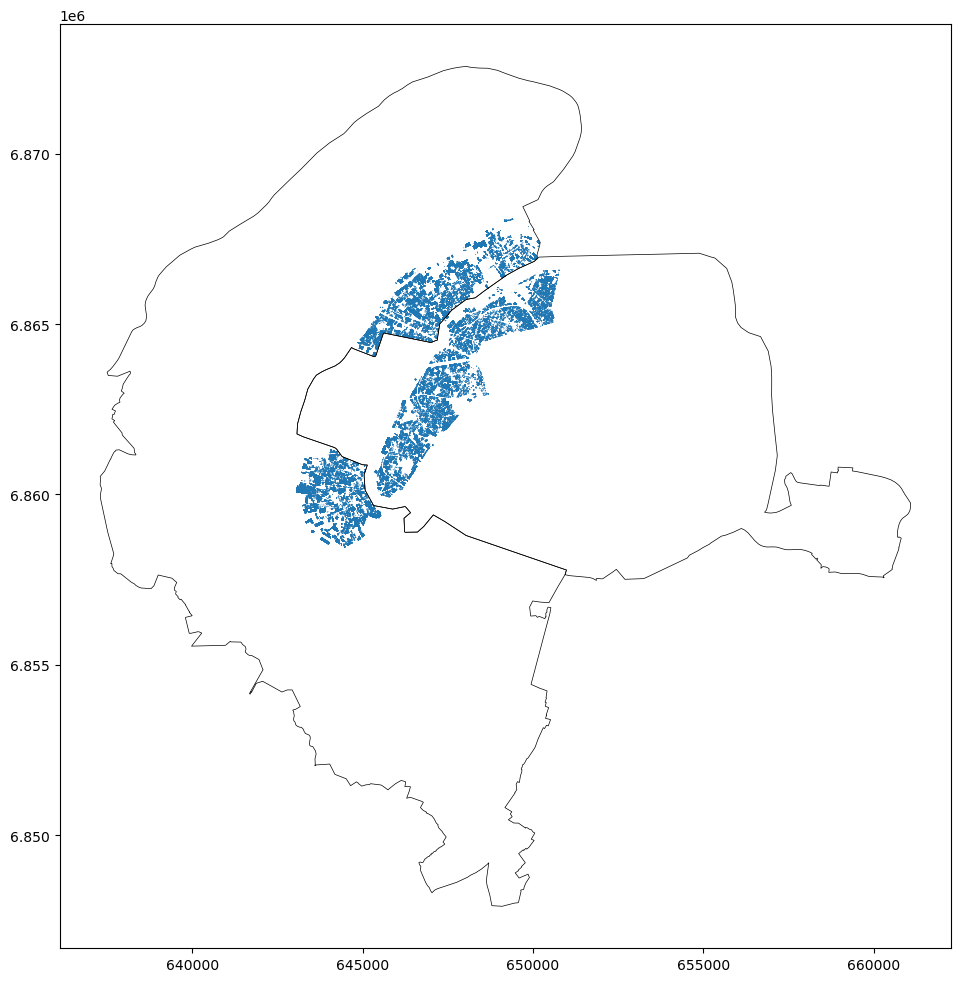

In [46]:
idf = cartiflette.carti_download(
    values=["11"],
    crs=4326,
    borders="DEPARTEMENT",
    vectorfile_format="geojson",
    filter_by="REGION",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

departements_paris_92 = idf.loc[
    idf["INSEE_DEP"].isin(["75", "92"])
].to_crs(2154)

fig, ax = plt.subplots(figsize=(12, 12))
base = departements_paris_92.boundary.plot(ax=ax, edgecolor="black", linewidth=0.5, figsize=(10, 10))

data_mut_et_insee_pour_vis = data_mut_ouest_et_insee
data_mut_et_insee_pour_vis["geometry"] = data_mut_et_insee_pour_vis["geometry"].to_crs(2154)

data_mut_et_insee_pour_vis.plot(ax=ax)

plt.show()



On a sélectionné ici au début du code les villes de Vanves et Issy les Moulineaux, d'où le fait que les tâches de couleur s'affichent sur une zone localisée (uniquement les villes concernées)
= > il faudra ajuster l'API et le fond de carte selon la commune choisie, mais au moins on sait le faire fonctionner grosso modo

VI. Differences in differences

On cherche à appliquer ce modèle à deux ensembles : l'Ouest parisien et le Sud parisien. Dans chaque ensemble, on établit un groupe "contrôle" (villes en bordures du périphérique) et un groupe "traitement" (arrondissements parisiens en bordure du périphérique). 

In [48]:
print(data_mut_ouest_et_insee['coddep'].unique())

['75' '92']


In [92]:
crtl_sud = data_mut_ouest_et_insee[data_mut_ouest_et_insee['coddep']=='92']
trtm_sud = data_mut_ouest_et_insee[data_mut_ouest_et_insee['coddep']=='75']

In [56]:
print(list(data_mut_ouest_et_insee.columns))

['idmutinvar', 'idopendata', 'datemut', 'anneemut', 'coddep', 'libnatmut', 'vefa', 'valeurfonc', 'nbcomm', 'l_codinsee', 'nbpar', 'l_idpar', 'nbparmut', 'sterr', 'nbvolmut', 'nblocmut', 'l_idlocmut', 'sbati', 'codtypbien', 'libtypbien', 'geometry', 'index_right', 'geo_point', 'dep', 'insee_com', 'nom_com', 'iris', 'code_iris', 'nom_iris', 'typ_iris', 'IRIS', 'COM_x', 'TYP_IRIS_x', 'LAB_IRIS_x', 'P_POP1564', 'P_POP1524', 'P_POP2554', 'P_POP5564', 'P_H1564', 'P_H1524', 'P_H2554', 'P_H5564', 'P_F1564', 'P_F1524', 'P_F2554', 'P_F5564', 'P_ACT1564', 'P_ACT1524', 'P_ACT2554', 'P_ACT5564', 'P_HACT1564', 'P_HACT1524', 'P_HACT2554', 'P_HACT5564', 'P_FACT1564', 'P_FACT1524', 'P_FACT2554', 'P_FACT5564', 'P_ACTOCC1564', 'P_ACTOCC1524', 'P_ACTOCC2554', 'P_ACTOCC5564', 'P_HACTOCC1564', 'P_HACTOCC1524', 'P_HACTOCC2554', 'P_HACTOCC5564', 'P_FACTOCC1564', 'P_FACTOCC1524', 'P_FACTOCC2554', 'P_FACTOCC5564', 'P_CHOM1564', 'P_CHOM1524', 'P_CHOM2554', 'P_CHOM5564', 'P_INACT1564', 'P_HINACT1564', 'P_FINACT15

In [53]:
import statsmodels.formula.api as sm
data_mut_ouest_et_insee['prix_m2'] = data_mut_ouest_et_insee['valeurfonc'] / data_mut_ouest_et_insee['stot']


In [76]:
print(list(data_mut_ouest_et_insee['DISP_MED'].unique()))

['39790', '44960', '36270', '37420', '29830', '28680', '35580', '51940', '33420', '30770', '33910', '38310', '39040', '38900', '38970', '34510', '20250', '55690', '24040', '46450', '42180', '40410', '25500', '48250', '40300', '40910', '51380', '21160', '33550', '56110', '49660', '21650', '43050', '42330', '36050', '53190', '32330', '51870', '36150', '41850', '35100', '23230', '62210', '24120', '22050', '49890', '42990', '29450', '47090', '51030', '44310', '50690', '40480', '43450', '41480', '26330', '25660', '38040', '44460', '42790', '48940', '35210', '37510', '28250', '32750', '38020', '40530', '32440', '39010', '23830', '47880', '35710', '41100', '47570', '30670', '41370', '22890', '39710', '37300', '58880', '55720', '28960', '47350', '33040', '34160', '40950', '31510', '38880', '36880', '27980', '41570', '29440', '48830', '39660', '36930', '46830', '21710', '48290', '26500', '34460', '19880', '40580', '39590', '48150', '17880', '33680', '51290', '47610', '44300', '25280', '41660', 

In [ ]:
print(len(data_mut_ouest_et_insee))
def est_un_nombre(valeur):
    try:
        a = str(valeur).replace(',', ".")
        float(a)
        return True
    except ValueError:
        return False

# Filtrage pour ne garder que les valeurs convertibles en nombre
data_mut_ouest_et_insee = data_mut_ouest_et_insee[data_mut_ouest_et_insee['DISP_MED'].apply(est_un_nombre)]
print(len(data_mut_ouest_et_insee))

77753
77368


In [ ]:
data_mut_ouest_et_insee['DISP_MED'] = data_mut_ouest_et_insee['DISP_MED'].astype(float)

/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [88]:
print(data_mut_ouest_et_insee["DISP_MED"].mean())

TypeError: can only concatenate str (not "int") to str

In [89]:
result = sm.ols(formula="prix_m2 ~ P_ACT1564 + P_CHOM1564 + C_ACT1564_CS3 + P_H1564 + P_MAISON", data=data_mut_ouest_et_insee).fit()
print(result.params)

Intercept        10097.920945
P_ACT1564           -5.159227
P_CHOM1564          -6.685845
C_ACT1564_CS3        4.931495
P_H1564              5.025820
P_MAISON           -10.436881
dtype: float64


In [90]:
print(result.pvalues)

Intercept         0.000000e+00
P_ACT1564        1.978400e-225
P_CHOM1564        5.766616e-50
C_ACT1564_CS3     0.000000e+00
P_H1564          1.062713e-129
P_MAISON          4.695519e-89
dtype: float64


In [94]:
print(crtl_sud['anneemut'].unique())

['2021' '2020' '2019' '2018' '2017' '2016' '2014']


In [95]:
crtl_sud_an = {}
for annee in crtl_sud['anneemut'].unique() : 
    crtl_sud_an[annee] = crtl_sud[crtl_sud['anneemut']==annee]

In [103]:
for annee in crtl_sud['anneemut'].unique() :
    print(annee)
    df = crtl_sud_an[annee]
    pred = result.params["Intercept"] 
    for covar in ["P_CHOM1564",'C_ACT1564_CS3', 'P_H1564', "P_MAISON", "P_ACT1564"]:
        pred +=  result.params[covar]*df[covar].mean()
    print((df['prix_m2'].mean() - pred)/df['prix_m2'].mean())  

2021
0.03392412980909746
2020
0.022934015402839868
2019
-0.026442552486586727
2018
-0.08869844618173407
2017
-0.14424207249159002
2016
-0.2149319585763163
2014
-0.21633204762634664


In [102]:
trtm_sud_an = {}
for annee in trtm_sud['anneemut'].unique() : 
    trtm_sud_an[annee] = trtm_sud[trtm_sud['anneemut']==annee]
for annee in trtm_sud['anneemut'].unique() :
    print(annee)
    df = trtm_sud_an[annee]
    pred = result.params["Intercept"] 
    for covar in ["P_CHOM1564",'C_ACT1564_CS3', 'P_H1564', "P_MAISON", "P_ACT1564"]:
        pred +=  result.params[covar]*df[covar].mean()
    print((df['prix_m2'].mean() - pred)/df['prix_m2'].mean())  

2021
0.1440737080255532
2020
0.1351639459114321
2019
0.09190293726582982
2018
0.030148242792345473
2017
-0.02141983013823401
2016
-0.09544074395960281
2014
-0.12202215690652


In [ ]:
isaure

In [52]:
data_mut_ouest_et_insee.columns


Index(['idmutinvar', 'idopendata', 'datemut', 'anneemut', 'coddep',
       'libnatmut', 'vefa', 'valeurfonc', 'nbcomm', 'l_codinsee',
       ...
       'P_ANEM_RP_GRAT', 'P_RP_SDB', 'P_RP_CCCOLL', 'P_RP_CCIND',
       'P_RP_CINDELEC', 'P_RP_GARL', 'P_RP_VOIT1P', 'P_RP_VOIT1',
       'P_RP_VOIT2P', 'stot'],
      dtype='object', length=238)

In [53]:
# Créer une copie pour travailler
data_diff = data_mut_ouest_et_insee.copy()

# Ajouter une colonne "groupe"
data_diff['groupe'] = data_diff['l_codinsee'].apply(
    lambda x: 'traitement' if x in ['75116', '75117'] else 
              'controle' if x in ['92012', '92024', '92044', '92051'] else 
              'hors_etude'
)

# Filtrer uniquement les groupes traitement et contrôle
data_diff = data_diff[data_diff['groupe'] != 'hors_etude']


In [57]:

cutoff_date = pd.to_datetime("2019-07-01")

data_diff['periode'] = data_diff['datemut'].apply(
    lambda x: 'avant' if x < cutoff_date else 'apres'
)
print(data_diff[['datemut', 'periode']].head())



     datemut periode
1 2021-03-18   apres
2 2021-06-02   apres
4 2021-02-26   apres
6 2021-05-11   apres
7 2021-04-14   apres


In [58]:
print(data_diff['periode'].value_counts())


periode
avant    47195
apres    35835
Name: count, dtype: int64


In [59]:
# Encodage binaire pour traitement et après
data_diff['traitement'] = (data_diff['groupe'] == 'traitement').astype(int)
data_diff['apres'] = (data_diff['periode'] == 'apres').astype(int)

# Vérifions les nouvelles colonnes
print(data_diff[['groupe', 'periode', 'traitement', 'apres']].head())


       groupe periode  traitement  apres
1  traitement   apres           1      1
2  traitement   apres           1      1
4  traitement   apres           1      1
6  traitement   apres           1      1
7  traitement   apres           1      1


In [60]:
print(data_diff['traitement'].value_counts())
print(data_diff['apres'].value_counts())


traitement
1    44028
0    39002
Name: count, dtype: int64
apres
0    47195
1    35835
Name: count, dtype: int64


In [61]:
print(data_diff.info())


<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 83030 entries, 1 to 109676
Columns: 242 entries, idmutinvar to apres
dtypes: datetime64[ms](1), float64(184), geometry(1), int64(2), object(54)
memory usage: 153.9+ MB
None


In [63]:
print(data_diff.groupby(['groupe', 'periode']).size())



groupe      periode
controle    apres      17089
            avant      21913
traitement  apres      18746
            avant      25282
dtype: int64


In [72]:
variables_controle = ['DISP_MED', 'DISP_RD', 
                      'P_ACT1564', 'P_CHOM1564', 
                      'P_RP_4060M2', 'P_RP_6080M2', 
                      'P_RP_PROP', 'P_RP_LOC', 
                      'P_ANEM_RP']


In [71]:
with open("colonnes_data.txt", "w") as f:
    for col in data_mut_ouest_et_insee.columns:
        f.write(col + "\n")





In [75]:

# Calculer le prix au m²
data_diff['prix_m2'] = data_diff['valeurfonc'] / data_diff['sbati']

# Vérifier un aperçu des données
print(data_diff[['valeurfonc', 'sbati', 'prix_m2']].head())


   valeurfonc  sbati       prix_m2
1    451000.0   30.0  15033.333333
2    701780.0   50.0  14035.600000
4    213650.0   19.0  11244.736842
6    854009.0   77.0  11091.025974
7    335000.0   34.0   9852.941176


In [81]:
import statsmodels.formula.api as smf

# Formuler le modèle Diff-in-Diff avec variables de contrôle
formule = 'prix_m2 ~ traitement + apres + traitement:apres + ' + ' + '.join(variables_controle)

# Ajuster le modèle
modele = smf.ols(formula=formule, data=data_diff).fit()

# Résultats
print(modele.summary())


ValueError: mismatch between column_names and columns coded by given terms

In [78]:
# Vérifiez les valeurs manquantes dans les colonnes utilisées
missing_values = data_diff[variables_utilisees].isnull().sum()
print("Valeurs manquantes par colonne :")
print(missing_values)


Valeurs manquantes par colonne :
prix_m2          0
traitement       0
apres            0
DISP_MED       274
DISP_RD        274
P_ACT1564        0
P_CHOM1564       0
P_RP_4060M2      0
P_RP_6080M2      0
P_RP_PROP        0
P_RP_LOC         0
P_ANEM_RP        0
dtype: int64


In [79]:
data_diff_clean = data_diff.dropna(subset=variables_utilisees)


In [82]:
# Liste des colonnes utilisées dans la formule
variables_utilisees = ['prix_m2', 'traitement', 'apres'] + variables_controle

# Vérifiez si toutes ces colonnes existent dans data_diff
missing_columns = [col for col in variables_utilisees if col not in data_diff.columns]
print("Colonnes manquantes :", missing_columns)


Colonnes manquantes : []
